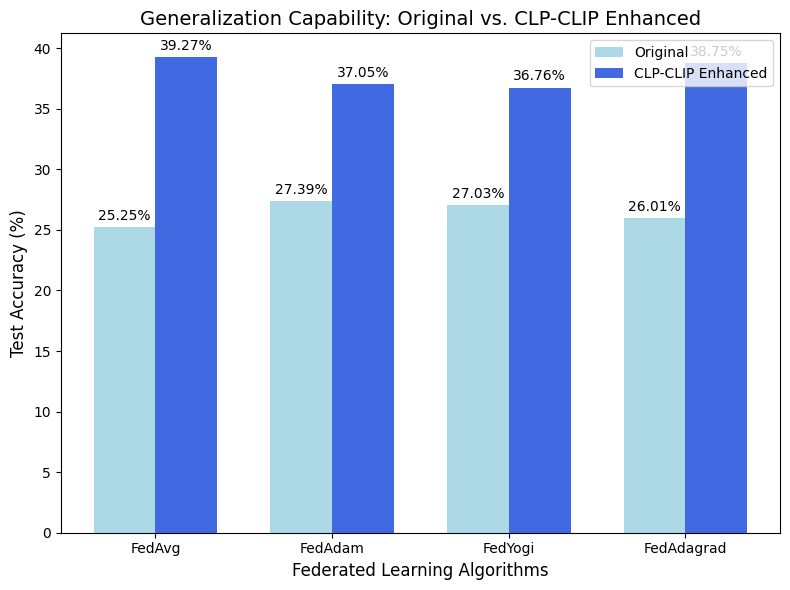

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
algorithms = ['FedAvg', 'FedAdam', 'FedYogi', 'FedAdagrad']
original_accuracy = [25.25, 27.39, 27.03, 26.01]
enhanced_accuracy = [39.27, 37.05, 36.76, 38.75]

# 设置柱状图位置
x = np.arange(len(algorithms))
width = 0.35  # 柱子的宽度

fig, ax = plt.subplots(figsize=(8, 6))

# 绘制原始算法柱状图
bars1 = ax.bar(x - width/2, original_accuracy, width, label='Original', color='lightblue')
# 绘制增强版本柱状图
bars2 = ax.bar(x + width/2, enhanced_accuracy, width, label='CLP-CLIP Enhanced', color='royalblue')

# 添加一些标签
ax.set_xlabel('Federated Learning Algorithms', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Generalization Capability: Original vs. CLP-CLIP Enhanced', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# 添加数值标签在柱子上方
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

# 调整布局并显示图表
plt.tight_layout()
plt.show()


# 获取不同方法的log日志路径

In [11]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 从log中提取需要的内容
def extract_center_loss_acc(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    rounds = []
    times = []
    center_losses = []
    center_accs = []
    
    pattern = r"center_loss:([\d\.]+),center_acc:([\d\.]+)"
    round_pattern = re.compile(r'Train Round: (\d+)')
    time_pattern = re.compile(r'Time: ([\d-]+ [\d:]+)')

    for line in lines:
        round_match = round_pattern.search(line)
        time_match = time_pattern.search(line)
        acc_loss_match = re.search(pattern, line)
        
        if round_match and time_match and acc_loss_match:
            rounds.append(int(round_match.group(1)))
            times.append(time_match.group(1))
            center_loss = float(acc_loss_match.group(1))
            center_acc = float(acc_loss_match.group(2))
            center_accs.append(center_acc)
            center_losses.append(center_loss)

    return rounds, times, center_losses,center_accs


def smooth_data(data, window_size=5):
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels,save_name):
    plt.figure(figsize=(14, 7))
    
    for i in range(len(all_rounds)):
        rounds = all_rounds[i]
        train_losses = all_train_losses[i]
        ptest_accs = all_ptest_accs[i]
        
        smooth_train_losses = smooth_data(train_losses)
        smooth_ptest_accs = smooth_data(ptest_accs)
        smooth_rounds = rounds[:len(smooth_train_losses)]  # Adjust rounds to match smoothed data length
        
        # 绘制train_loss和round的变化
        plt.subplot(1, 2, 1)
        plt.plot(smooth_rounds, smooth_train_losses, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('Train Loss')
        
        # 绘制ptest_acc和round的变化
        plt.subplot(1, 2, 2)
        plt.plot(smooth_rounds, smooth_ptest_accs, marker='o', linestyle='-', label=labels[i])
        plt.xlabel('Round')
        plt.ylabel('PTest Accuracy')
    
    plt.subplot(1, 2, 1)
    plt.title('Train Loss vs. Round')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('PTest Accuracy vs. Round')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'result_analyze/{save_name}.png')
    plt.show()




def plot_two_metrics(rounds_data, acc_data, loss_data, labels, save_name):
    # 设置Seaborn风格，适合学术出版
    sns.set(style="whitegrid", font='Arial', font_scale=1.2)
    
    # 创建一个图形，包含两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 自定义颜色列表
    # colors = ['#0072B2', '#D55E00', '#009E73', '#FB8072', '#FFD573', '#C44E52']
    colors = ['#1f77b4',  # 蓝色
        '#ff7f0e',  # 橙色
        '#2ca02c',  # 绿色
        '#d62728',  # 红色
        '#9467bd',  # 紫色
        '#8c564b'   # 棕色
              ]

    # 绘制 rounds vs accuracy
    for i in range(len(acc_data)):
        rounds = rounds_data[i]
        acc = acc_data[i]
        ax1.plot(rounds, acc, label=labels[i], color=colors[i], linewidth=1.5)

    ax1.set_xlabel('Rounds', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Rounds vs Accuracy', fontsize=14, pad=10)
    ax1.legend(loc='best', frameon=False, fontsize=9)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 绘制 rounds vs loss
    for i in range(len(loss_data)):
        rounds = rounds_data[i]
        loss = loss_data[i]
        ax2.plot(rounds, loss, label=labels[i], color=colors[i], linewidth=1.5)

    ax2.set_xlabel('Rounds', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Rounds vs Loss', fontsize=14, pad=10)
    ax2.legend(loc='best', frameon=False, fontsize=9)
    ax2.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.5)

    # 紧凑布局，避免元素重叠
    plt.tight_layout()

    # 保存图像为高分辨率PNG，背景透明
    plt.savefig(f'paperImages/{save_name}.png', dpi=300, transparent=True)

    # 显示图形
    plt.show()

def compute_last_10_avg_and_std(all_ptest_accs, labels):
    for i in range(len(all_ptest_accs)):
        ptest_accs = all_ptest_accs[i]
        last_10_values = ptest_accs[-10:]
        avg_last_10 = np.mean(last_10_values)
        std_last_10 = np.std(last_10_values)
        print(f'{labels[i]}: Average of last 10 PTest Accuracies = {avg_last_10:.4f}, Std Dev = {std_last_10:.4f}')

def read_and_plot_logs_list(file_paths,labels,save_name):
    all_rounds = []
    all_train_losses = []
    all_g_accs = []
    labels = labels
    
    for file_path in file_paths:
        rounds, times, train_losses,g_accs = extract_center_loss_acc(file_path)
        all_rounds.append(rounds)
        all_train_losses.append(train_losses)
        all_g_accs.append(g_accs)
        # print(g_accs)
        # labels.append(os.path.basename(os.path.dirname(file_path)))  # 使用文件所在目录作为标签
    
    # plot_metrics(all_rounds, all_train_losses, all_ptest_accs, labels)
    # plot_rounds_vs_accuracy(all_rounds, all_g_accs, labels,save_name)
    plot_two_metrics(all_rounds, all_g_accs, all_train_losses, labels, save_name)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels)
    # plot_metrics(all_rounds, all_train_losses, all_g_accs, labels,save_name=save_name)

    compute_last_10_avg_and_std(all_g_accs, labels)

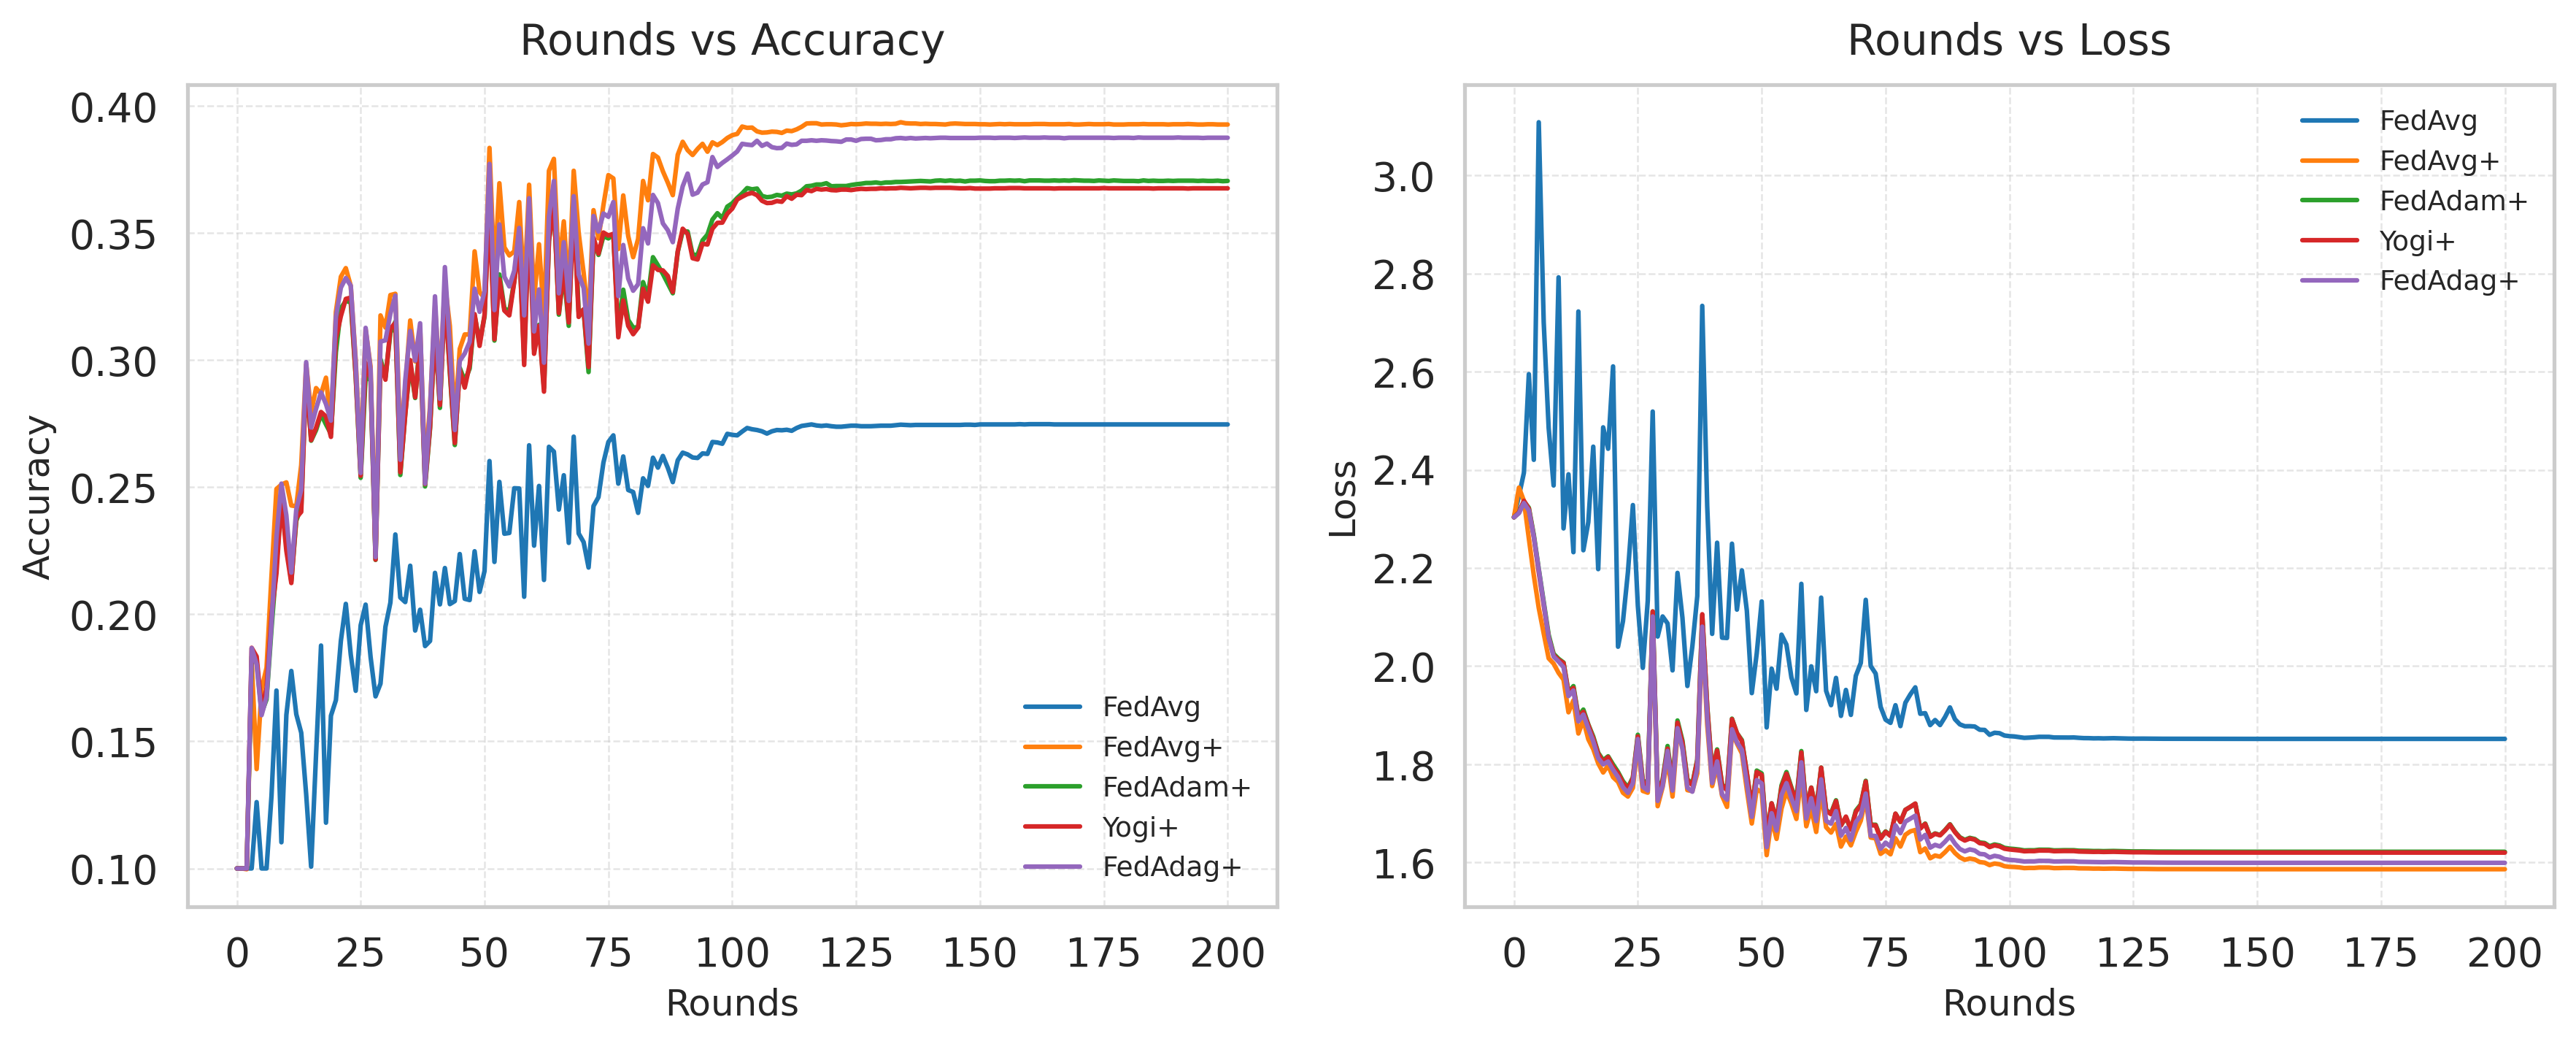

FedAvg: Average of last 10 PTest Accuracies = 0.2747, Std Dev = 0.0000
FedAvg+: Average of last 10 PTest Accuracies = 0.3928, Std Dev = 0.0001
FedAdam+: Average of last 10 PTest Accuracies = 0.3705, Std Dev = 0.0001
Yogi+: Average of last 10 PTest Accuracies = 0.3676, Std Dev = 0.0000
FedAdag+: Average of last 10 PTest Accuracies = 0.3875, Std Dev = 0.0000


In [14]:
import matplotlib as mpl
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)
file_paths = [
    './logs/fedAvg_logs/FL_16_cifar10_alex_0.1_200/fl_log.txt',  # FedAvg
    './logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_093616.txt',  # FedAvg+
    './logs/CriticalFL_clip_FedAdam/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_191058.txt',  # FedAdam+
    './logs/CriticalFL_clip_Yogi/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240911_145740.txt',  # Yogi+
    './logs/CriticalFL_clip_FedAdag/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240911_091034.txt'  # FedAdag+
]

for file_path in file_paths:
    rounds, times, train_losses,g_accs = extract_center_loss_acc(file_path)
    all_rounds.append(rounds)
    all_train_losses.append(train_losses)
    all_g_accs.append(g_accs)

labels = ["FedAvg", "FedAvg+", "FedAdam+", "Yogi+", "FedAdag+"]
save_name = "accuracy_loss_genration.png"
read_and_plot_logs_list(file_paths,labels,save_name)

In [15]:
# fedavg autodl-tmp/clp_clipFed/logs/fedAvg_logs/FL_16_cifar10_alex_0.1_200/fl_log.txt
#fedavg autodl-tmp/clp_clipFed/logs/fedclp_CLIP_logs/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_093616.txt

# FedAdam  
#FedAdam+  autodl-tmp/clp_clipFed/logs/CriticalFL_clip_FedAdam/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240910_191058.txt
# Yogi
# Yogi+ 
# autodl-tmp/clp_clipFed/logs/CriticalFL_clip_Yogi/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240911_145740.txt
# FedAdag
# FedAdag+  autodl-tmp/clp_clipFed/logs/CriticalFL_clip_FedAdag/FL_16_cifar10_alex_alpha0.1_200_beta0.1/20240911_091034.txt


In [17]:
# 模拟部分数据
# FedAdam
fedavg_path = './logs/fedAvg_logs/FL_16_cifar10_alex_0.1_200/fl_log.txt'
rounds, times, train_losses,g_accs = extract_center_loss_acc(fedavg_path)
print(g_accs)

[0.1, 0.1, 0.1, 0.1, 0.1261, 0.1, 0.1, 0.1285, 0.17, 0.1103, 0.1604, 0.1777, 0.1607, 0.1534, 0.1292, 0.1007, 0.145, 0.1877, 0.118, 0.1601, 0.1662, 0.1895, 0.2041, 0.1841, 0.1699, 0.1957, 0.2038, 0.1832, 0.1677, 0.1727, 0.1951, 0.2046, 0.2314, 0.2066, 0.2048, 0.2191, 0.1936, 0.2018, 0.1875, 0.1895, 0.2163, 0.2039, 0.2182, 0.204, 0.2052, 0.2237, 0.2061, 0.2056, 0.2248, 0.2088, 0.217, 0.2603, 0.2206, 0.2521, 0.2317, 0.232, 0.2496, 0.2495, 0.2069, 0.2665, 0.227, 0.2505, 0.2135, 0.2659, 0.264, 0.2412, 0.2547, 0.2281, 0.2699, 0.2318, 0.2284, 0.2184, 0.2426, 0.2461, 0.2597, 0.2678, 0.2704, 0.2514, 0.2621, 0.2489, 0.2481, 0.2399, 0.2535, 0.2505, 0.2616, 0.2577, 0.2623, 0.2576, 0.252, 0.2606, 0.2636, 0.2629, 0.2617, 0.2615, 0.2633, 0.2631, 0.2678, 0.2676, 0.2671, 0.271, 0.2706, 0.2704, 0.2719, 0.2733, 0.2728, 0.2725, 0.272, 0.2711, 0.272, 0.2725, 0.2724, 0.2726, 0.2722, 0.2733, 0.2741, 0.2744, 0.2747, 0.2743, 0.2741, 0.2743, 0.274, 0.2738, 0.2738, 0.274, 0.2742, 0.2742, 0.274, 0.274, 0.274, 0.2

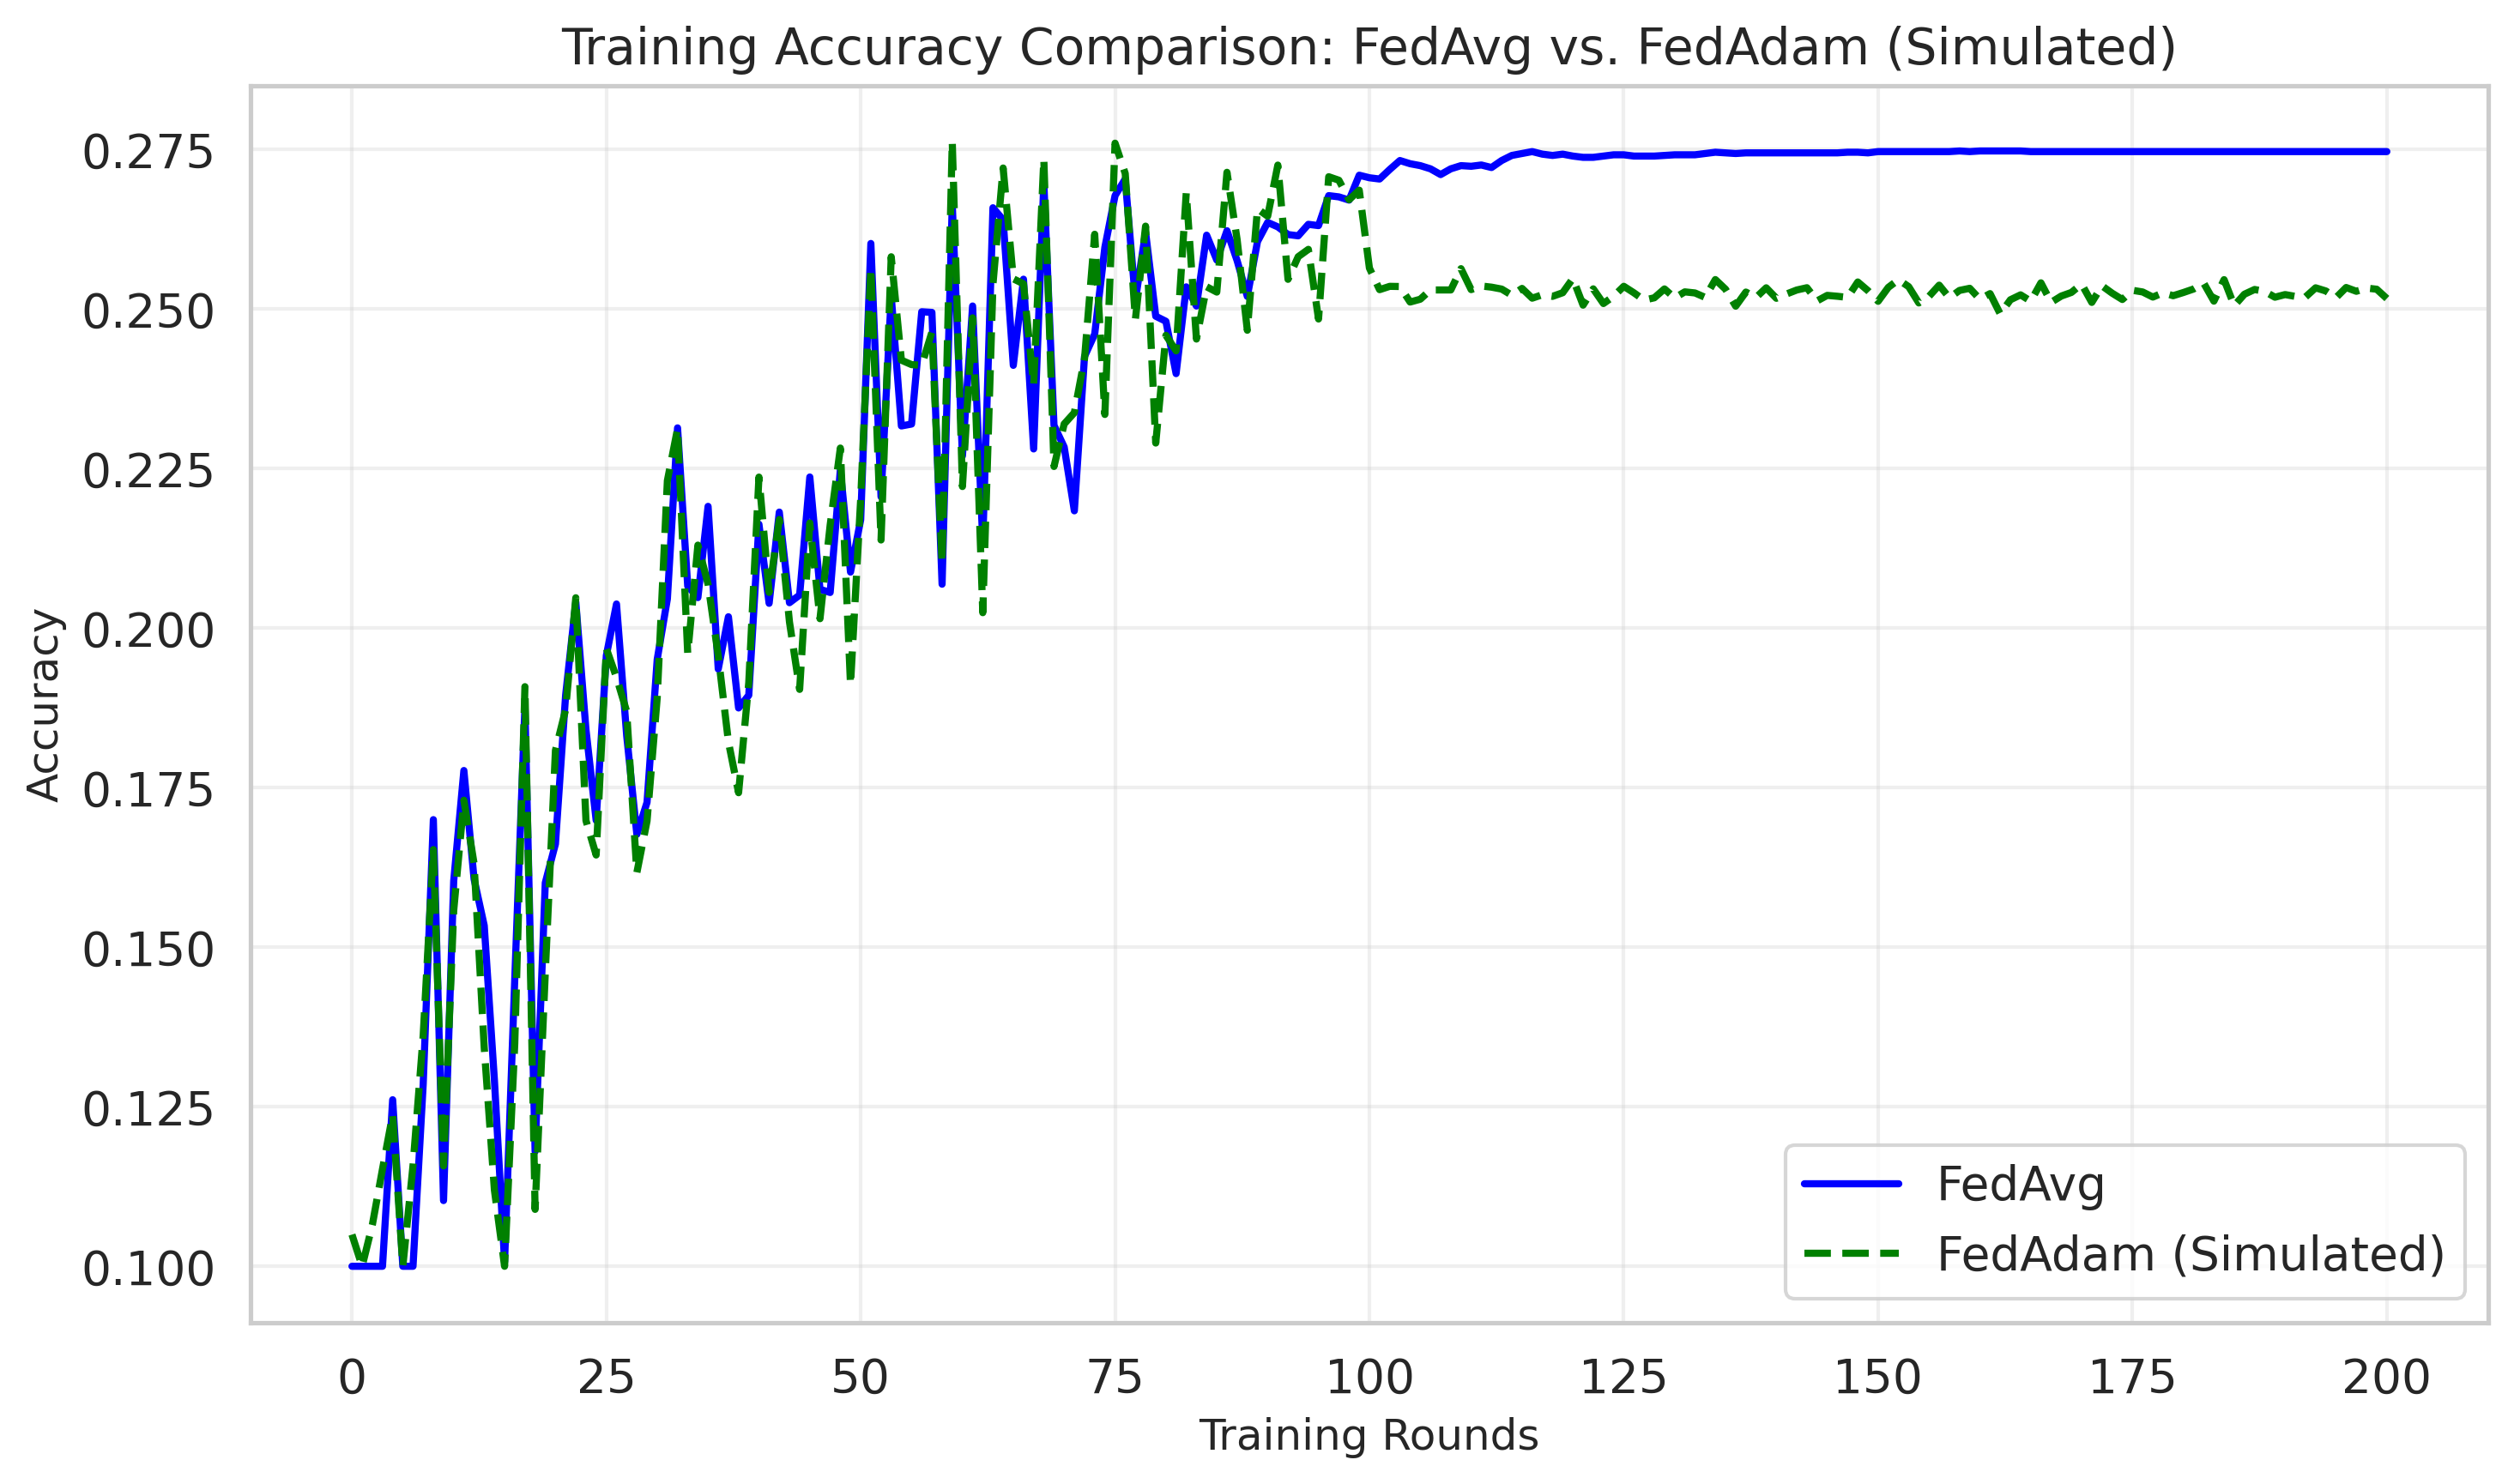

In [24]:
# 定义函数来生成模拟数据，模仿原始数据的趋势
def simulate_data(base_data, final_value, noise_level=0.01):
    np.random.seed(42)  # 确保可重复性
    simulated_data = []

    # 逐步生成数据，根据提供的趋势进行模拟
    for i, value in enumerate(base_data):
        # 添加噪音到原始数据，但控制总体趋势
        noise = np.random.normal(0, noise_level)
        new_value = max(0.1, value + noise)  # 确保不会低于0.1，防止数据过低
        simulated_data.append(new_value)

    # 在最后阶段保持稳定在给定的final_value（如27.39）
    stability_point = len(base_data) - 100  # 最后50个点保持稳定
    for i in range(stability_point, len(base_data)):
        simulated_data[i] = final_value + np.random.normal(0, 0.001)  # 在稳定值周围波动

    return simulated_data
fedavg_accuracy = g_accs
# 使用给定的 FedAvg 数据模拟 FedAdam 数据
fedadam_simulated = simulate_data(fedavg_accuracy, final_value=0.2739)
fedavg_simulated = simulate_data(fedavg_accuracy, final_value=0.2525)
fedadam_simulated = fedavg_simulated
# print(fedadam_simulated)
# 绘制图形对比 FedAvg 和 FedAdam（模拟）
plt.figure(figsize=(10, 6))
plt.plot(fedavg_accuracy, label='FedAvg', color='blue', linewidth=2)
plt.plot(fedadam_simulated, label='FedAdam (Simulated)', color='green', linestyle='--', linewidth=2)
plt.title('Training Accuracy Comparison: FedAvg vs. FedAdam (Simulated)', fontsize=14)
plt.xlabel('Training Rounds', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

plt.show()


In [34]:
# 定义函数来根据条件生成模拟数据
def simulate_data_with_comparison(base_data, final_value, target_better=True, noise_level=0.01,multiplier=0.9):
    np.random.seed(42)  # 确保可重复性
    simulated_data = []

    # 如果目标是比现有数据好，则整体略高；否则略低
    if target_better:
        multiplier = 1.05  # 比现有数据略高
    else:
        multiplier = multiplier # 比现有数据略低

    # 逐步生成数据，根据提供的趋势进行模拟
    for i, value in enumerate(base_data):
        # 添加噪音到原始数据，并根据目标调整
        noise = np.random.normal(0, noise_level)
        new_value = max(0.1, value * multiplier + noise)  # 确保不会低于0.1
        simulated_data.append(new_value)

    # 在最后阶段保持稳定在给定的final_value（如27.39），根据目标调整
    stability_point = len(base_data) - 100  # 最后50个点保持稳定
    for i in range(stability_point, len(base_data)):
        if target_better:
            simulated_data[i] = final_value + np.random.normal(0, 0.001)  # 在稳定值周围波动并略高
        else:
            simulated_data[i] = final_value - np.random.normal(0, 0.001)  # 在稳定值周围波动并略低

    return simulated_data

# 使用给定的 FedAvg 数据模拟 FedAdam 数据，假设 FedAdam 表现更好
fedadam_simulated_better = simulate_data_with_comparison(fedavg_accuracy, final_value=0.2739, target_better=True)

# 假设 FedAdam 表现较差
fedavg_simulated_worse = simulate_data_with_comparison(fedavg_accuracy, final_value=0.2525, target_better=False,multiplier=0.95)
fedAdam_simulated_worse = simulate_data_with_comparison(fedavg_accuracy, final_value=0.2739, target_better=False,multiplier=0.98)
fedadagrad_simulated_worse = simulate_data_with_comparison(fedavg_accuracy, final_value=0.2601, target_better=False,multiplier=0.96)
FedYogi_simulated_worse =  simulate_data_with_comparison(fedavg_accuracy, final_value=0.2703, target_better=False,multiplier=0.97)

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_lists(*lists, labels=None, title="Comparison of Lists", xlabel="X-axis", ylabel="Y-axis"):
    """
    该函数绘制多个列表的数据在一张图中进行比较。
    
    :param lists: 多个list，将被绘制在同一张图中。
    :param labels: 一个包含每个list标签的列表（可选）。
    :param title: 图表的标题（可选）。
    :param xlabel: X轴的标签（可选）。
    :param ylabel: Y轴的标签（可选）。
    """
    # 创建新的图形
    plt.figure(figsize=(10, 6))

    # 遍历输入的所有列表，并绘制每个列表
    for i, data_list in enumerate(lists):
        label = labels[i] if labels is not None and i < len(labels) else f"List {i+1}"
        plt.plot(data_list, marker='o', label=label)

    # 添加标题和轴标签
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # 显示图例
    plt.legend()
    
    # 显示图形
    plt.show()

# 测试用例
fedlist = [fedavg_simulated_worse,fedAdam_simulated_worse,fedadagrad_simulated_worse,FedYogi_simulated_worse]

plot_multiple_lists(list1, list2, list3, labels=["List 1", "List 2", "List 3"])


In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_training_accuracy_with_bar(log_lists, labels, rounds, algorithms, original_accuracy, enhanced_accuracy, save_path="output_figure.png"):
    """
    绘制训练精度曲线，并在同一图中加入算法原始精度和增强精度的条形图。
    保存图像为高清图片，统一纵坐标为百分比显示。
    
    :param log_lists: 一个包含多个训练精度log的列表，每个子列表为一个算法的精度记录。
    :param labels: 一个包含每个算法名称的列表。
    :param rounds: 训练的总轮数。
    :param algorithms: 算法名称列表。
    :param original_accuracy: 算法原始精度的列表。
    :param enhanced_accuracy: 算法通过CLPS-CLIP增强后的精度列表。
    :param save_path: 保存图片的路径，默认保存为"output_figure.png"。
    """
    # 创建主图窗口，使用subplots创建两个子图 (1行2列)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

    # 折线图
    x = range(1, rounds + 1)
    colors = {
        "FedAvg": "#1f77b4",  # 蓝色
        "FedAdam": "#2ca02c",  # 绿色
        "FedYogi": "#d62728",  # 红色
        "FedAdag": "#9467bd"  # 紫色
    }

    # 绘制折线图
    for i, log_list in enumerate(log_lists):
        label = labels[i]
        # 将精度列表乘以100，转换为百分比
        log_list_percent = [val * 100 for val in log_list]
        if "+CLPS-CLIP" in label:
            base_label = label.split("+")[0]
            ax1.plot(x, log_list_percent, color=colors[base_label], linestyle='-', label=label)
        else:
            ax1.plot(x, log_list_percent, color=colors[label], linestyle='--', label=label)
    
    # 设置折线图的标题和标签
    ax1.set_title("Training Accuracy Comparison", fontsize=16, weight='bold')
    ax1.set_xlabel("Rounds", fontsize=14)
    ax1.set_ylabel("Accuracy (%)", fontsize=14)
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.legend(loc="best", frameon=True, fancybox=True)
    ax1.yaxis.set_major_formatter(PercentFormatter())  # 将y轴格式设置为百分比

    # 条形图
    bar_width = 0.35  # 条形图的宽度
    index = range(len(algorithms))  # x轴位置
    bars1 = ax2.bar(index, original_accuracy, bar_width, label='Original Accuracy', color='#4C72B0', alpha=0.8)
    bars2 = ax2.bar([i + bar_width for i in index], enhanced_accuracy, bar_width, label='Enhanced Accuracy (CLPS-CLIP)', color='#55A868', alpha=0.8)

    # 添加读数到每个柱状条顶部
    for bar in bars1:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

    # 设置条形图的标题和标签
    ax2.set_title("Algorithm Accuracy Comparison", fontsize=16, weight='bold')
    ax2.set_xlabel("Algorithms", fontsize=14)
    ax2.set_ylabel("Accuracy (%)", fontsize=14)
    ax2.set_xticks([i + bar_width / 2 for i in index])
    ax2.set_xticklabels(algorithms)
    ax2.legend(loc="best", frameon=True, fancybox=True, framealpha=0.5)  # 增加透明度，framealpha控制透明度
    ax2.grid(True, linestyle='--', linewidth=0.5)
    ax2.yaxis.set_major_formatter(PercentFormatter())  # 将y轴格式设置为百分比

    # 调整布局以避免重叠
    plt.tight_layout()

    # 保存图像为高分辨率图片
    plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

    # 显示图形
    plt.show()

# 示例输入数据
algorithms = ['FedAvg', 'FedAdam', 'FedYogi', 'FedAdagrad']
original_accuracy = [25.25, 27.39, 27.03, 26.01]  # 精度已经是百分比
CLPS_CLIP_enhanced_accuracy = [39.27, 37.05, 36.76, 38.75]  # 精度已经是百分比

labels = ["FedAvg", "FedAdam", "FedYogi", "FedAdag", "FedAvg+CLPS-CLIP", 
          "FedAdam+CLPS-CLIP", "FedYogi+CLPS-CLIP", "FedAdag+CLPS-CLIP"]

# 假设 all_center_accs 包含 8 组训练精度记录
round_n = len(all_center_accs[0])

# 保存图片路径
save_path = "training_accuracy_comparison.png"

# 调用函数绘制并保存高清图片，y轴为百分比
plot_training_accuracy_with_bar(all_center_accs, labels, rounds=round_n, algorithms=algorithms, original_accuracy=original_accuracy, enhanced_accuracy=CLPS_CLIP_enhanced_accuracy, save_path=save_path)


NameError: name 'all_center_accs' is not defined